### Custom Autoencoder(PyTorch)

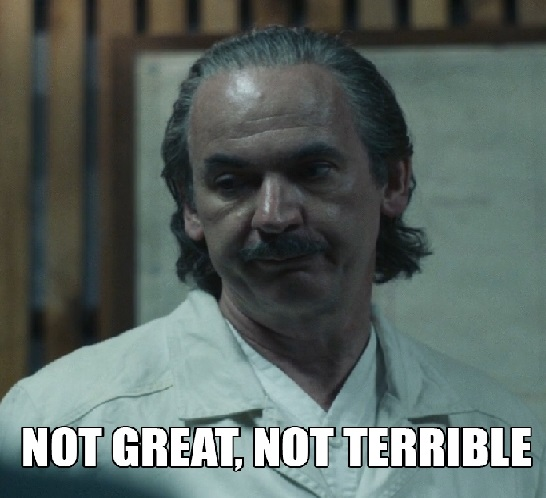

#### In my notebook I use code of this guy
[https://github.com/Bjarten/early-stopping-pytorch](http://)
##### (Unfortunetly I can not install this package correctly)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df_train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/train.csv')
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/test.csv')
df_sub = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv')

In [ ]:
X = df_train.drop(['id', 'loss'], axis = 1)
y = df_train['loss']

In [ ]:
Test = df_test.drop(['id'], axis = 1).values
Test.shape

#### Scaling 
##### (Transform "Train" and "Test" with "Train"`s Fit) 

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = y.values
Test = scaler.transform(Test)
X.shape, y.shape, Test.shape

#### For a (number rows) % 64 == 0 in the table, extend the table by 880 rows
##### (This is usefull for GPU calculation)

In [ ]:
X = np.vstack((X, X[:880]))
y = np.concatenate((y, y[:880]), axis=0)
X.shape, y.shape

In [ ]:
class CustomTabulaDataset(Dataset):
    def __init__(self, labels, features, transform=None, target_transform=None):
        self.labels = torch.from_numpy(labels.astype(np.float32))
        self.features = torch.from_numpy(features.astype(np.float32))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

#### You can use pin_memory.
##### (It`s slightly improve learning speed)

In [ ]:
batch_size = 64
#batch_size = 100

features_train, features_test, targets_train, targets_test = train_test_split(X, 
                                                                              y, 
                                                                              test_size=0.2,
                                                                              shuffle = True)

train_data = CustomTabulaDataset(targets_train, features_train)
test_data = CustomTabulaDataset(targets_test, features_test)

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for featur, target in test_dataloader:
    print("Shape of X [N, C, H, W]: ", featur.shape)
    print("Shape of y: ", target.shape, target.dtype)
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
class TorchNNModel(torch.nn.Module):
    def __init__(self, dim_inp, L640, L384, L256, L128, L64, L32, L16, dim_out):
        super(TorchNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(dim_inp, L640),
#             nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(L640, L640),
            nn.ELU(),
            nn.Linear(L640, L384),
            nn.ELU(),
            nn.Linear(L384, L384),
            nn.ELU(),
#             nn.Dropout(p=0.5),
            nn.Linear(L384, L256),
#             nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(L256, L256),
            nn.ELU(),
            nn.Linear(L256, L128),
#             nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(L128, L128),
            nn.ELU(),
            nn.Linear(L128, L64),
            nn.ELU(),
            nn.Linear(L64, L64),
            nn.ELU(),
            nn.Linear(L64, L32),
            nn.ELU(),
            nn.Linear(L32, L32),
            nn.ELU(),
            nn.Linear(L32, L16),
            nn.ELU(),
            nn.Linear(L16, L16),
            nn.ELU(),
            nn.Linear(L16, L16),
            nn.ELU(),
            nn.Linear(L16, L32),
            nn.ELU(),
            nn.Linear(L32, L32),
            nn.ELU(),
            nn.Linear(L32, L64),
            nn.ELU(),
            nn.Linear(L64, L64),
            nn.ELU(),
            nn.Linear(L64, L128),
            nn.ELU(),
            nn.Linear(L128, L128),
            nn.ELU(),
            nn.Linear(L128, L256),
            nn.ELU(),
            nn.Linear(L256, L256),
            nn.ELU(),
            nn.Linear(L256, L384),
            nn.ELU(),
            nn.Linear(L384, L384),
            nn.ELU(),
            nn.Linear(L384, L640),
            nn.ELU(),
            nn.Linear(L640, L640),
            nn.ELU(),
            nn.Linear(L640, dim_out)           
        )
    
    def forward(self, x):
        x1 = self.features(x)
        return x1

dim_inp, L640, L384, L256, L128, L64, L32, L16, dim_out = 100, 640, 384, 256, 128, 64, 32, 16, 1

model = TorchNNModel(dim_inp, L640, L384, L256, L128, L64, L32, L16, dim_out).to(device)
print(model)

In [ ]:
# EarlyStopping

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Apply EarlyStopping

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, delta = 5, verbose=True)
    
    for epoch in tqdm(range(1, n_epochs + 1)):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_dataloader, 1):
            # clear the gradients of all optimized variables
            data = data.to(device=device)
            target = target.to(device=device)
            
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in test_dataloader:
            data = data.to(device=device)
            target = target.to(device=device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-7)

In [ ]:
batch_size = 100
n_epochs = 500

# early stopping patience; how long to wait after last time validation loss improved.
patience = 5

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim() # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#### Make prediction on Test dataset

In [ ]:
with torch.no_grad():
    pred= model(torch.tensor(Test, dtype=torch.float).to(device=device))
    print(f'Predicted: "{pred.shape}"')

#### Prediction transferring from GPU to CPU memory

In [ ]:
pred = pred.cpu()

In [ ]:
pred = pred.squeeze(1).numpy()
pred = np.absolute(pred)
result = pd.DataFrame(pred)

In [ ]:
result = pd.merge(df_test['id'], result, left_index = True, right_index = True)

In [ ]:
result.columns = df_sub.columns

In [ ]:
result.to_csv("Torch_result.csv", index=False)

#### If you find this notebook usefull, please upvote)
#### If you know how we can improve this net please comment)
#### Thank you in advance!

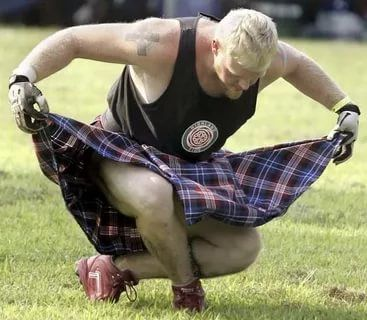